## Imports

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

## Data Loading

In [36]:
def loadJSON(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def loadPCA():
    X_train_pca = pd.read_csv(r'data/music_train_pca.csv')

    y_train_pca = np.array(X_train_pca.iloc[:, -1])
    non_music = X_train_pca[y_train_pca == 0]
    music = X_train_pca[y_train_pca == 1][:len(X_train_pca[y_train_pca == 0])]
    X_train_pca = music.append(non_music, ignore_index=True).sample(frac=1, random_state = 0)
    y_train_pca = np.array(X_train_pca.iloc[:, -1])
    X_train_pca = X_train_pca.iloc[:,:-1].values

    print("Loaded PCA training set")
    
    X_val_pca = pd.read_csv(r'data/music_validation_pca.csv').values
    y_val_pca = X_val_pca[:,-1]
    X_val_pca = X_val_pca[:,:-1]
    print("Loaded PCA validation set")
    
    X_test_pca = pd.read_csv(r'data/music_test_pca.csv').values
    y_test_pca = X_test_pca[:,-1]
    X_test_pca = X_test_pca[:,:-1]
    print("Loaded PCA test set")
    
    scaler = StandardScaler()
    scaler.fit(X_train_pca)
    X_train_scaled = scaler.transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)
    X_test_scaled = scaler.transform(X_test_pca)
    
    
    return (X_train_scaled, y_train_pca, X_val_scaled, y_val_pca, X_test_scaled, y_test_pca, scaler)

## Classifier

In [32]:
def profit_score(y_true, y_pred, **kwargs):
    rewardDict = dict()
    #(True Value, Predicted Value)
    rewardDict[(0,0)] = 0
    rewardDict[(0,1)] = -3
    rewardDict[(1,0)] = 0
    rewardDict[(1,1)] = 1
    
    reward = 0
    if len(y_true) != len(y_pred):
        print("Arrays are of two different lengths!!!")
        return -1000000
    for index in range(len(y_true)):
        reward += rewardDict[(y_true[index],y_pred[index])]
    return reward

def plotROC(solution, prediction, classifierName):
    lw = 2
    fpr, tpr, _ = roc_curve(solution, prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(classifierName))
    plt.legend()
    plt.show()
    
def getBestClassifier():
    logistic_regression = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                             intercept_scaling=1, max_iter=100, multi_class='warn',
                                             penalty='l2', random_state=None, solver='liblinear',
                                             tol=0.0001, verbose=0, warm_start=False)
    random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                           max_depth=1000, max_features='auto', max_leaf_nodes=None,
                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                           min_samples_leaf=2, min_samples_split=6,
                                           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                                           oob_score=False, random_state=0, verbose=0, warm_start=False)
    nn = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
                       beta_2=0.999, early_stopping=False, epsilon=1e-08,
                       hidden_layer_sizes=100, learning_rate='constant',
                       learning_rate_init=0.001, momentum=0.9,
                       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                       random_state=0, shuffle=True, solver='adam', tol=0.0001,
                       validation_fraction=0.1, verbose=False, warm_start=False)
    voting = VotingClassifier(estimators=[('lr', logistic_regression), ('rf', random_forest), ('nn', nn)], voting="soft")
    return (voting, "ensemble")

## Post processing

In [33]:
def post_processing(y):
    return filtering(majority_vote(y))

def majority_vote(y, window = 90):
    """
    Slides a window over the input and puts the label to a majority vote
    """
    y_new = []
    maxR = len(y)
    for i in range(maxR):
        l = i - window
        if l < 0:
            l = 0
        r = i + window
        if r > maxR - 1:
            r = maxR - 1
        y_new.append(np.bincount(y[l:r]).argmax())
    return y_new

def filtering(y, threshold = 50):
    """
    Filters out segments of music that are shorter than 10 seconds 
    Every Frame is 200ms * 5 * 10 = 50
    """
    y_string = str1 = ''.join(str(e) for e in y)
    y_new = np.zeros(len(y))
    musicIndexStart = 0
    musicIndexStop = 0
    while musicIndexStart != -1 and musicIndexStop != -1:
        if musicIndexStop - musicIndexStart > threshold:
            y_new[musicIndexStart:musicIndexStop] = np.ones(musicIndexStop - musicIndexStart)
        musicIndexStart = y_string.find("1",musicIndexStop)
        musicIndexStop = y_string.find("0",musicIndexStart)
    return y_new

Loaded PCA training set
Loaded PCA validation set
Loaded PCA test set
|Training ensemble on PCA
|Validation set
|-Confusion Matrix: [0.399217   0.0062113  0.08134917 0.51322253]
|-Accuracy: 91.24
|-Profit: 26277 / 83.18%
L==============================


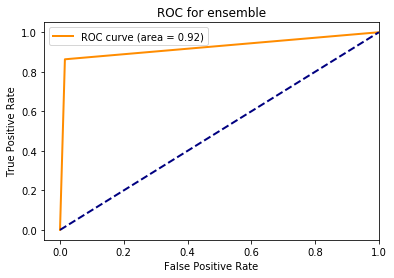

|Test set
|-Confusion Matrix: [0.15340888 0.01528183 0.11282345 0.71848584]
|-Accuracy: 87.19
|-Profit: 36445 / 80.91%
L==============================


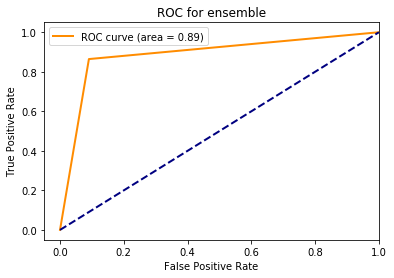

In [42]:
X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca, y_test_pca, scaler = loadPCA()
classifier, name = getBestClassifier()

max_val_score = np.sum(y_val_pca == 1)
max_test_score = np.sum(y_test_pca == 1)

print("===============================")
print("|Training {} on PCA".format(name))
print("===============================")

classifier.fit(X_train_pca, y_train_pca)

print("===============================")
print("|Validation set")
print("===============================")

y_pred = post_processing(classifier.predict(X_val_pca))
accuracy = np.around(accuracy_score(y_val_pca, y_pred) * 100, decimals = 2)
val_profit = profit_score(y_val_pca, y_pred)
print("|-Confusion Matrix: {}".format(confusion_matrix(y_val_pca, y_pred).ravel()/len(y_pred)))
print("|-Accuracy: {}".format(accuracy))
print("|-Profit: {} / {}%".format(val_profit, np.around(val_profit* 100/max_val_score,decimals = 2)))
print("L==============================")
plotROC(y_val_pca, y_pred, name)
      
    
print("===============================")
print("|Test set")
print("===============================")

y_pred_test = post_processing(classifier.predict(X_test_pca))
accuracy = np.around(accuracy_score(y_test_pca, y_pred_test) * 100, decimals = 2)
test_profit = profit_score(y_test_pca, y_pred_test)
print("|-Confusion Matrix: {}".format(confusion_matrix(y_test_pca, y_pred_test).ravel()/len(y_pred_test)))
print("|-Accuracy: {}".format(accuracy))
print("|-Profit: {} / {}%".format(test_profit, np.around(test_profit* 100/max_test_score,decimals = 2)))
print("L==============================")
plotROC(y_test_pca, y_pred_test, name)

In [39]:
def predict_music_files(classifier, scaler):
    print("===============================")
    print("|Load Data for prediction")
    print("===============================")


    indeces = range(15,30)
    filename = "data/{}.music.pca.csv"
    output_filename = "predictions_music/{}.music.txt"

    for index in indeces:
        print(index)
        X_predict_pca = pd.read_csv(filename.format(index)).values
        X_predict_scaled = scaler.transform(X_predict_pca)
        y_pred = classifier.predict(X_predict_scaled)
        with open(output_filename.format(index), "w") as output:
            output.write("\n".join(y_pred.astype(str).tolist()))
        print("Wrote file {}".format(output_filename.format(index)))

|Load Data for prediction


In [89]:
def directCompare():
    y_pred_non = classifier.predict(X_val_pca)
    y_pred_smooth = majority_vote(y_pred_non)
    y_pred_filter = filtering(y_pred_smooth)

    fig = plt.figure(figsize = [15,5])

    ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.3], yticks = [0,1], yticklabels = ["No Music","Music"], title = "Before Post Processing",
                      ylabel = "Class")
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.3], yticks = [0,1], yticklabels = ["No Music","Music"],title = "After Post Processing",
                      ylabel = "Class", xlabel = "Frame")

    x = np.linspace(0, 10)
    ax1.plot(y_pred_non)
    ax2.plot(y_pred_filter)
    fig.show()

def plotPred():
    y_pred_non = classifier.predict(X_val_pca)
    y_pred_smooth = majority_vote(y_pred_non)
    y_pred_filter = filtering(y_pred_smooth)
    plt.figure(figsize = [15,5])
    plt.plot(y_pred_filter)
    #plt.plot(y_pred_smooth, color = "green", alpha = 0.5)
    plt.title("Prediction for the validation after filtering")
    plt.xlabel("Frame")
    plt.yticks([0,1],["No Music","Music"])
    plt.ylabel("Class")
    #plt.legend()
    plt.show()

y_pred_non = classifier.predict(X_val_pca)
y_pred_smooth = majority_vote(y_pred_non)
y_pred_filter = filtering(y_pred_smooth)
max_val_profit = max_val_score = np.sum(y_val_pca == 1)
val_profit_non = profit_score(y_val_pca, y_pred_non)
val_profit_smooth = profit_score(y_val_pca, y_pred_smooth)
val_profit_filter = profit_score(y_val_pca, y_pred_filter)

print(val_profit_non*100/max_val_profit, val_profit_smooth*100/max_val_profit, val_profit_filter*100/max_val_profit)

69.19497293361613 82.89594479090823 83.18401975371174
